<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
<div hidden>
    $$
    \newcommand{\reals}{\mathbb{R}}
    \newcommand{\naturals}{\mathbb{N}}
    \newcommand{\integers}{\mathbb{Z}}
    \newcommand{\prob}{\mathbb{P}}
    \newcommand{\expect}{\mathbb{E} }
    \newcommand{\b}[1]{\mathbf{#1}}
    \newcommand{\bs}[1]{\boldsymbol{#1}}
    \newcommand{\c}[1]{\mathcal{#1}}
    \newcommand{mat}[2]{\left[\,\begin{array}{#1}#2\end{array}\,\right]}
    $$
</div>

# COMPSCI 371 Homework 4

_**Group Members:**_

### Problem 0 (3 points)

## Part 1: Intuition and Dimensionality 

In [1]:
import numpy as np
def standardize(s, mean, variance):
    return (s - mean) / np.sqrt(variance)

In [2]:
rng = np.random.default_rng(1)
e = np.exp(1)

densities = [
    lambda n, d: standardize(rng.beta(a=1, b=1, size=(n, d)), 1/2, 1/12),
    lambda n, d: standardize(rng.exponential(scale=1, size=(n, d)), 1, 1),
    lambda n, d: standardize(rng.lognormal(size=(n, d)), 1/2, (e - 1) * e),
    lambda n, d: rng.normal(size=(n, d)),
    lambda n, d: standardize(rng.uniform(size=(n, d)), 1/2, 1/12),
    lambda n, d: standardize(rng.wald(1, 1, size=(n, d)), 1, 1)
]

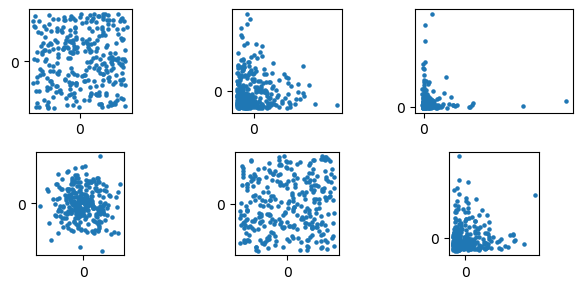

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
n, d = 300, 2
ax = plt.subplots(2, 3, figsize=(7, 3), tight_layout=True)[1]
k = 0
for r in range(2):
    for c in range(3):
        s = densities[k](n, d)
        a = ax[r, c]
        a.scatter(s[:, 0], s[:, 1], s=5)
        a.set_xticks([0])
        a.set_yticks([0])
        a.set_aspect(1)
        k += 1

### Problem 1.1 (Exam Style)

### Problem 1.2

In [4]:
def create_density(d, p):
    ratio = 0
    means = 0
    for fn in densities:
        points = fn(p, d)
        n = np.linalg.norm(points, axis=1)
        means += np.mean(n)
        normalize = (np.std(n) / np.mean(n)) * 100
        ratio += normalize
    print(f"Ratio for {d}: " ,np.round(ratio / len(densities), 4),'\n', f"Mean for {d}: ", np.round(means / len(densities), 4))

In [5]:
create_density(16, 10_000)
create_density(100, 10_000)
create_density(1600, 10_000)

Ratio for 16:  28.9244 
 Mean for 16:  3.8846
Ratio for 100:  13.1524 
 Mean for 100:  10.0876
Ratio for 1600:  3.7282 
 Mean for 1600:  40.8117


## Part 2: Stochastic Risk Minimization and The Bayes Classifier

### Problem 2.1 (Exam Style)

## Part 3: Regularization and Validation 

### Problem 3.1

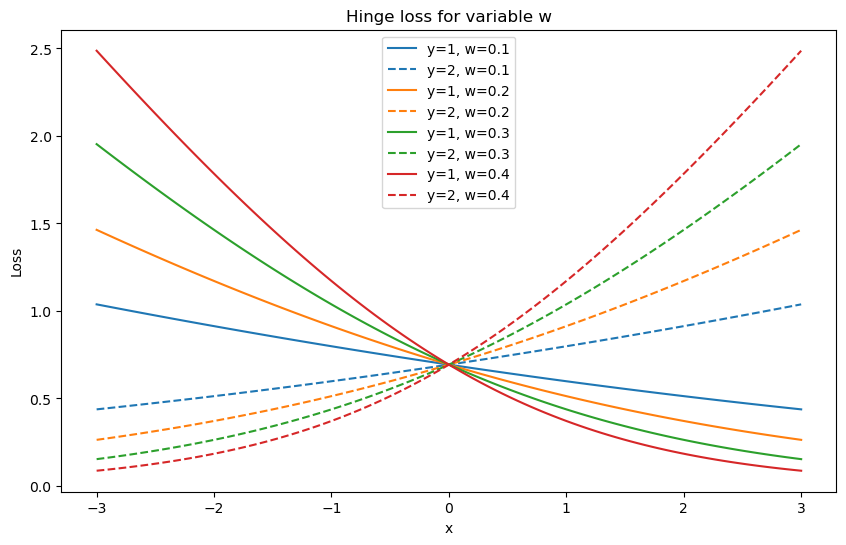

In [6]:
def hinge_loss(y, a):
    e1 = np.exp(a[0])
    e2 = np.exp(a[1])
    return np.log(e1 + e2) - a[y-1]

def a1(w, x):
    return np.outer(w, x)
def a2(w, x):
    return -np.outer(w, x)

ys = np.array([1, 2])
ws = np.array([.1, .2, .3, .4])
xs = np.linspace(-3, 3, 100)

a_s = a1(ws, xs)
a_s2 = a2(ws, xs)

fig, ax = plt.subplots(figsize=(10, 6))

for c in range(4): 
    for r in range(2): 
        losses = []
        for i in range(len(xs)):
            a = np.array([a_s[c, i], a_s2[c, i]])
            loss = hinge_loss(ys[r], a)
            losses.append(loss)
        
        _dotted = '-' if ys[r] == 1 else '--' 
        col = f'C{c}'
        ax.plot(xs, losses, linestyle=_dotted, color=col, label=f'y={ys[r]}, w={ws[c]:.1f}')


ax.set_title('Hinge loss for variable w')
ax.set_xlabel('x')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

L_T(w) is a decreasing function of w.


when w → ∞, the correct label approaches +∞, and the incorrect label's activation approaches −∞. The softmax loss then approaches 0 as the model becomes more and more confident.

so, L_T(∞) = 0


### Problem 3.2 (Exam Style)

### Problem 3.3: Regularization

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
x, x_test, y, y_test = train_test_split(
    digits.data, digits.target, test_size=797,
    random_state=3, shuffle=True, stratify=digits.target
)
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=800,
    random_state=3, shuffle=True, stratify=y
)
mnist = SimpleNamespace(
    train=SimpleNamespace(x=x_train, y=y_train),
    validate=SimpleNamespace(x=x_val, y=y_val),
    test=SimpleNamespace(x=x_test, y=y_test)
)

msg = 'set sizes: T {}, V {}, S {}'
print(msg.format(len(mnist.train.y), len(mnist.validate.y), len(mnist.test.y)))

set sizes: T 200, V 800, S 797


In [17]:
from sklearn.linear_model import LogisticRegression

def softmax_classifier(t, c):
    return LogisticRegression(C=c, max_iter=1000, random_state=3).fit(t.x, t.y)

In [18]:
def best_validation(c_set, t, v):
    accs = []
    c_vals = []
    top_c = c_set[0]
    top_h = softmax_classifier(t, top_c)
    top_acc = 0

    for c_val in c_set:
        h_hat = softmax_classifier(t, c_val)

        acc = h_hat.score(v.x, v.y)

        c_vals.append(c_val)
        accs.append(acc)
        if top_acc < acc:
            top_acc = acc
            top_c = c_val
            top_h = h_hat
    best_acc = max(accs)
    top_c = np.round(top_c, 4)
    return [top_c, top_h, c_vals, accs, best_acc]

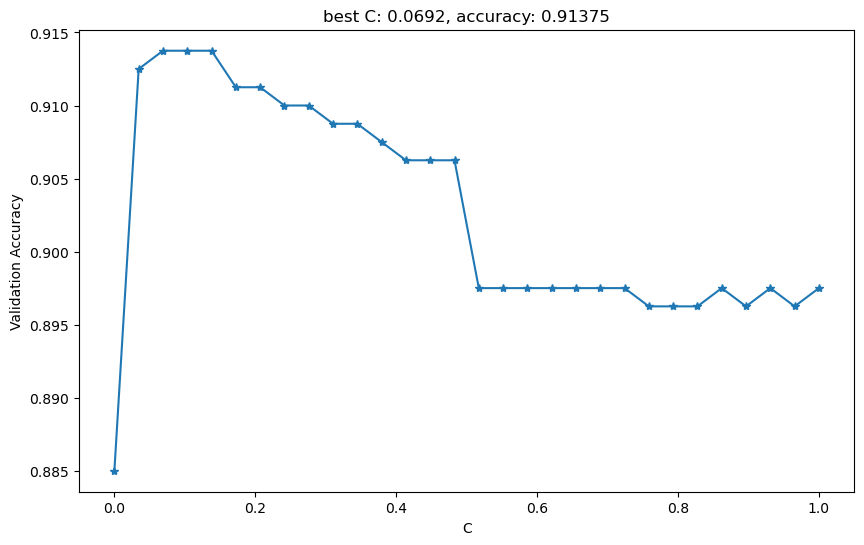

In [19]:
train = mnist.train
validate = mnist.validate

c_vals = np.linspace(.0002, 1, 30)
out = best_validation(c_vals, train, validate)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(c_vals, out[3], label='validation accuracy', marker='*')

ax.set_title(f'best C: {out[0]}, accuracy: {out[4]}')
ax.set_xlabel('C')
ax.set_ylabel('Validation Accuracy')
plt.show()

In [20]:
tsx = mnist.test.x
tsy = mnist.test.y

test_score = np.round(out[1].score(tsx, tsy), 4)
print("test score:", test_score, 'with C:', out[0])

test score: 0.9247 with C: 0.0692


In [21]:
x_all = np.concatenate((mnist.train.x, mnist.validate.x), axis=0)
y_all = np.concatenate((mnist.train.y, mnist.validate.y), axis=0)
all_tr = SimpleNamespace(x=x_all, y=y_all)

h_all = softmax_classifier(all_tr, out[0])

val_acc_all = h_all.score(validate.x, validate.y)
print("Validation score from combined training set:", val_acc_all)

ts_acc_all = np.round(h_all.score(tsx, tsy), 4)
print("Test score from combined training set:", ts_acc_all)

Validation score from combined training set: 1.0
Test score from combined training set: 0.9711


### Problem 3.4 (Exam Style)

#### the validation loss is misleading because we have trained h_all on the validation set, so logically it will have a score of 1 because it has seen the data beforehand. 

## Part 4: The Bootstrap 

#### 1) (1-p)**k
#### 2) 1 - (1-p)**k
#### 3) 1 - p**k

### Problem 4.2

In [43]:
import numpy as np

def sampleIndices(rng, n):
    trIdx = rng.choice(n, size=n, replace=True)
    valIdx = list(set(range(n)) - set(trIdx))
    return trIdx, valIdx

def evaluateModelOnBag(rng, t, C, n):
    trIdx, valIdx = sampleIndices(rng, n)
    
    trX = t.x[trIdx]
    trY = t.y[trIdx]
    valX = t.x[valIdx]
    valY = t.y[valIdx]

    trData = SimpleNamespace(x=trX, y=trY)
    valData = SimpleNamespace(x=valX, y=valY)

    model = softmax_classifier(trData, C)
    return model.score(valData.x, valData.y)

def runBootstrapForC(C, t, k, rng):
    n = len(t.x)
    accs = []
    cnt = 0
    while cnt < k:
        acc = evaluateModelOnBag(rng, t, C, n)
        accs.append(acc)
        cnt += 1
    return np.mean(accs)

def findBestC(cSet, t, k):
    rng = np.random.default_rng()
    bestC = None
    bestAcc = 0
    i = 0
    while i < len(cSet):
        C = cSet[i]
        avgAcc = runBootstrapForC(C, t, k, rng)
        if avgAcc > bestAcc:
            bestAcc = avgAcc
            bestC = C
        i += 1
    return bestC

def bootstrap(cSet, t, k):
    bestC = findBestC(cSet, t, k)
    bestModel = softmax_classifier(t, bestC)
    return bestModel, bestC


In [55]:
c_vals = np.linspace(.0002, 1, 30)
k = 15

best_model, best_C = bootstrap(c_vals, all_tr, k)

tr_acc = best_model.score(all_tr.x, all_tr.y)
ts_acc = np.round(best_model.score(mnist.test.x, mnist.test.y), 4)

In [59]:
print("The predictor was trained 450 times: 30 (values of C) x 15 (K) = 450")
print("training accuracy:", tr_acc)
print("test accuracy:", ts_acc)
print("No, the model is not overfitting, on previously unseen data, it is scoring 95%. The training accuracy is off (100%) because it has previously seen the data.")

The predictor was trained 450 times: 30 (values of C) x 15 (K) = 450
training accuracy: 1.0
test accuracy: 0.9586
No, the model is not overfitting, on previously unseen data, it is scoring 95%. The training accuracy is off (100%) because it has previously seen the data.
